In [1]:
%matplotlib inline

In [100]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import KFold, cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# from surprise import evaluate 
from surprise.model_selection.validation import cross_validate

sns.set_style("darkgrid")

# ИИ, препоръчай ми филм!

### Как работят основните machine learning алгоритми и какво е влиянието на балона на филтрите



## Резюме

<b> Алгоритмите за машинно самообучение, свързани с препоръчване </b> са едни от най-използваните прилложения, още от зараждането на това направление. 

Разработката тук е свързана с [журналистически материал, който предстои да бъде публикуван](https://docs.google.com/document/d/134zZr_pZLMu49uEu0ppKht0ytunXujS5IIcL5bi5kiU/edit?usp=sharing) на сайта „Дигитални истории“, разказваща накратко за основните направления в областта на алгоритмите за препоръчване.

Основните подходи са два: колаборативно филтриране и филтриране, базирано на съдържанието. В по-модерните решения се използва своеобразна комбинация,така че да се използват силните страни и на двата подхода. 

Колаборация, или сътрудничество, ще рече, че хората работят заедно, за да постигнат даден резултат. Това стои в основата на колаборативното филтриране. Същият принцип, който споменахме и продължаваме да използваме и днес. А на езика на продажбите: „Хората, които купиха…, купиха и…“. Целта на алгоритмите в този случай е да обработи данните така, че максимално да потърси общите черти в избора на различните потребители, така че да изведе общите точки.

Като цяло подходът е следният. Алгоритъмът събира хората, които са давали максимално близки рейтинги, както потребителя, на когото ще препоръчваме. После данните се използват, за да се изчисли колко е вероятно хората със сходен вкус да харесат и друг продукт от същата група. Измежду хората, харесали любимите ви филми, да намерим средните показатели за следващия филм и да видим кои са най-високи. Като, разбира се, опитаме да игнорираме например филмите, които имат твърде малко оценки, потребителите, които дават твърде разнопосочни числа. Или, т.нар. „пристрастие“, което в света на технологиите общо взето всички наричат с английския термин “bias”.

Филтрирането, базирано на съдържание, обръща наобратно перспективата, базирайки се на отделните единици, нека в случая използваме филми. Сравняват се оценките на потребителите за всяка двойка филми и на базата на това се определя какъв би бил рейтингът на този, който още не е гледал втория филм.

Една от компаниите пионери в тази област и същевременно доказано най-успешна в нея, е „Нетфликс“. Именно това, което се знае за техните алгоритми ще разгледаме в настоящия проект.

In [6]:
def readFile(file_path, rows=100000):
    data_dict = {'Cust_Id' : [], 'Movie_Id' : [], 'Rating' : [], 'Date' : []}
    f = open(file_path, "r")
    count = 0
    for line in f:
        count += 1
        if count > rows:
            break
            
        if ':' in line:
            movidId = line[:-2] # remove the last character ':'
            movieId = int(movidId)
        else:
            customerID, rating, date = line.split(',')
            data_dict['Cust_Id'].append(customerID)
            data_dict['Movie_Id'].append(movieId)
            data_dict['Rating'].append(rating)
            data_dict['Date'].append(date.rstrip("\n"))
    f.close()
            
    return pd.DataFrame(data_dict)

In [8]:
df = readFile('combined_data.txt', rows=100000)


This dataset was constructed to support participants in the Netflix Prize.  See
http://www.netflixprize.com for details about the prize.

The movie rating files contain over 100 million ratings from 480 thousand
randomly-chosen, anonymous Netflix customers over 17 thousand movie titles.  The
data were collected between October, 1998 and December, 2005 and reflect the
distribution of all ratings received during this period.  The ratings are on a
scale from 1 to 5 (integral) stars. To protect customer privacy, each customer
id has been replaced with a randomly-assigned id.  The date of each rating and
the title and year of release for each movie id are also provided.

In [9]:
df.head()

,Cust_Id,Movie_Id,Rating,Date
0,2532865,4500,4,2005-07-26
1,573364,4500,3,2005-06-20
2,1696725,4500,3,2004-02-27
3,1253431,4500,3,2004-03-31
4,1265574,4500,2,2003-09-01


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Movie_Id,99977.0,4512.6969,6.617195,4500.0,4506.0,4512.0,4520.0,4522.0


In [11]:
df['Rating'] = df['Rating'].astype(float)

In [12]:
df.index = np.arange(0,len(df))
df.shape

(99977, 4)

In [90]:
grouped_by_movies = df.groupby('Movie_Id').agg(['count'])
movie_count = grouped_by_movies.shape[0]
grouped_by_movies

,Cust_Id,Rating,Date
,count,count,count
Movie_Id,,,
4500,258,258,258
4501,595,595,595
4502,104,104,104
4503,1779,1779,1779
4504,176,176,176
4505,238,238,238
4506,33731,33731,33731
4507,3445,3445,3445


In [91]:
df['Movie_Id'].value_counts()


4506    33731
4520    26500
4517     8440
4508     5939
4522     5499
4507     3445
4519     2806
4512     2656
4509     2516
4515     2179
4503     1779
4516     1233
4521      962
4501      595
4500      258
4505      238
4511      237
4518      235
4513      199
4504      176
4514      131
4510      119
4502      104
Name: Movie_Id, dtype: int64

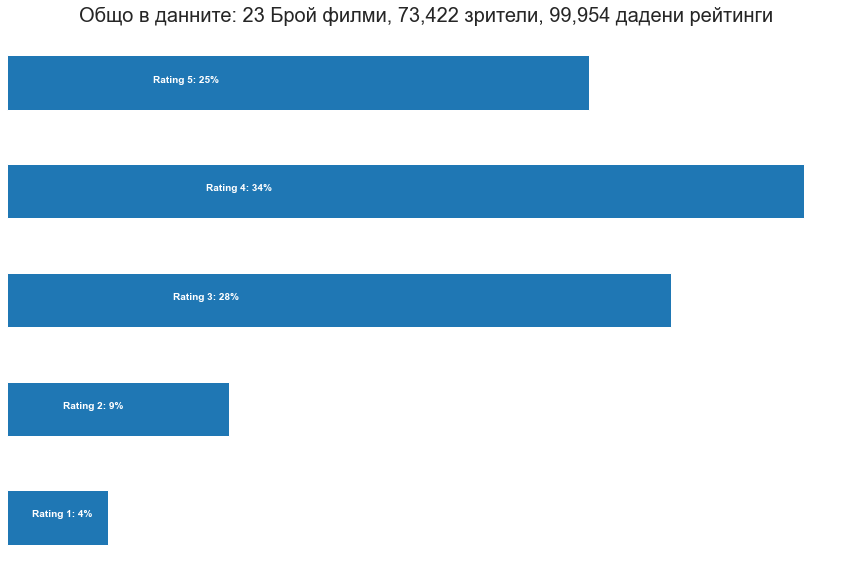

In [96]:
ratings = df.groupby('Rating')['Rating'].agg(['count'])

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = ratings.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Общо в данните: {:,} Брой филми, {:,} зрители, {:,} дадени рейтинги'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(ratings.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, ratings.iloc[i-1][0]*100 / ratings.sum()[0]), color = 'white', weight = 'bold')

In [86]:
f = ['count','mean']
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary

,count,mean
Movie_Id,,
4500,258,3.329457
4501,595,3.043697
4502,104,2.144231
4503,1779,3.213603
4504,176,3.153409
4505,238,2.470588
4506,33731,3.923898
4507,3445,3.546299
4508,5939,3.731436


In [87]:
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
print('Минимален брой ревюта на филм: {}'.format(movie_benchmark))

Movie minimum times of review: 2716.0


In [89]:
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Минимален брой ревюта на потребител: {}'.format(cust_benchmark))

Минимален брой ревюта на потребител: 1.0


In [15]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.head(10)

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
5,6,1997.0,Sick
6,7,1992.0,8 Man
7,8,2004.0,What the #$*! Do We Know!?
8,9,1991.0,Class of Nuke 'Em High 2
9,10,2001.0,Fighter


In [16]:
reader = Reader()

data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
svd = SVD()
# Run 5-fold cross-validation and print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0161  1.0246  1.0314  1.0241  1.0205  1.0233  0.0051  
MAE (testset)     0.7981  0.8061  0.8085  0.8032  0.8047  0.8041  0.0035  
Fit time          4.65    4.97    5.73    5.47    5.53    5.27    0.40    
Test time         0.15    0.14    0.25    0.14    0.17    0.17    0.04    


{'test_rmse': array([1.01608189, 1.0246391 , 1.03137858, 1.02409594, 1.02051876]),
 'test_mae': array([0.79807674, 0.80613525, 0.80852218, 0.80318803, 0.80471543]),
 'fit_time': (4.646022081375122,
  4.967203855514526,
  5.7286036014556885,
  5.466476202011108,
  5.531293153762817),
 'test_time': (0.15262675285339355,
  0.1386704444885254,
  0.25432276725769043,
  0.13961577415466309,
  0.1695103645324707)}

In [32]:
df_573364 = df[(df['Cust_Id'] == '1265574') & (df['Rating'] >= 1)]
df_573364 = df_573364.set_index('Movie_Id')
df_573364 = df_573364.join(df_title)['Name']
df_573364.head()

Movie_Id
4500     Open Hearts
4506    Class Action
Name: Name, dtype: object

In [33]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [34]:
titles = df_title.copy()

titles['Estimate_Score'] = titles['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)
titles = titles.sort_values(by=['Estimate_Score'], ascending=False)

In [35]:
titles.head(10)

,Movie_Id,Year,Name,Estimate_Score
4508,4509,1977.0,Little House on the Prairie: Season 4,4.043448
4520,4521,2002.0,Wire in the Blood: Justice Painted Blind,3.977433
4505,4506,1961.0,Breakfast at Tiffany's,3.972830
4521,4522,1998.0,Independent's Day,3.808656
4519,4520,1995.0,Grumpier Old Men,3.751580
4507,4508,1966.0,Star Trek: The Original Series: Vols. 1-15,3.717082
11844,11845,1955.0,Summertime,3.650030
11845,11846,1985.0,Prizzi's Honor,3.650030
11846,11847,2005.0,Dust to Glory,3.650030
11843,11844,1967.0,Barefoot in the Park,3.650030


In [97]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_p)

Movie_Id  4500  4501  4502  4503  4504  4505  4506  4507  4508  4509  ...  \
Cust_Id                                                               ...   
1000079    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1000095    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1000122    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1000145    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1000192    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
999892     NaN   NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN  ...   
999903     NaN   NaN   NaN   NaN   NaN   NaN   2.0   NaN   NaN   NaN  ...   
99993      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
999944     NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN   NaN   NaN  ...   
999972     NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN   NaN   NaN  ...   

## Втори модел
Колаборативно филтриране

In [99]:
reader = Reader()


In [101]:
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

In [102]:
svd=SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0250  1.0266  1.0222  1.0246  0.0018  
MAE (testset)     0.8061  0.8128  0.7999  0.8063  0.0053  
Fit time          3.68    3.69    3.89    3.75    0.10    
Test time         0.20    0.19    0.18    0.19    0.01    


{'test_rmse': array([1.02504145, 1.02655874, 1.02224852]),
 'test_mae': array([0.80607565, 0.81284009, 0.79993142]),
 'fit_time': (3.676368236541748, 3.6909008026123047, 3.891273260116577),
 'test_time': (0.1965024471282959, 0.19448041915893555, 0.1845073699951172)}

In [116]:
user = df[(df['Cust_Id'] == '999944') & (df['Rating'] > 2)]
user = user.set_index('Movie_Id')
user = user.join(df_title)['Name']
print(user)
print(df[(df['Cust_Id'] == '999944')])

Movie_Id
4506    Class Action
Name: Name, dtype: object
      Cust_Id  Movie_Id  Rating        Date
12013  999944      4506     5.0  2000-12-21
74017  999944      4520     2.0  2000-12-21


In [117]:
#prediction

user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]
user_785314

,index,Movie_Id,Year,Name
0,0,1,2003.0,Dinosaur Planet
1,1,2,2004.0,Isle of Man TT 2004 Review
2,2,3,1997.0,Character
3,3,4,1994.0,Paula Abdul's Get Up & Dance
4,4,5,2004.0,The Rise and Fall of ECW
...,...,...,...,...
17765,17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17766,17767,2004.0,Fidel Castro: American Experience
17767,17767,17768,2000.0,Epoch
17768,17768,17769,2003.0,The Company


In [118]:
# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

In [120]:
user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

In [121]:
user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

       index    Year                                        Name  \
4505    4505  1961.0                      Breakfast at Tiffany's   
4521    4521  1998.0                           Independent's Day   
4519    4519  1995.0                            Grumpier Old Men   
4507    4507  1966.0  Star Trek: The Original Series: Vols. 1-15   
0          0  2003.0                             Dinosaur Planet   
11853  11853  1939.0                      Only Angels Have Wings   
11858  11858  1996.0                    Star Trek: First Contact   
11857  11857  1974.0                        Good Times: Season 2   
11856  11856  2000.0                      The Man Show: Season 2   
11855  11855  1962.0                                 Half Ticket   

       Estimate_Score  
4505         3.970097  
4521         3.827132  
4519         3.743160  
4507         3.709489  
0            3.650030  
11853        3.650030  
11858        3.650030  
11857        3.650030  
11856        3.650030  
11855      

In [122]:
def recommend(movie_title, min_count):
  print("For movie ({})".format(movie_title))
  print("- Top 10 movies recommended based on Pearsons'R correlation - ")
  i = int(df_title.index[df_title['Name'] == movie_title][0])
  target = df_p[i]
  similar_to_target = df_p.corrwith(target)
  corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
  corr_target.dropna(inplace = True)
  corr_target = corr_target.sort_values('PearsonR', ascending = False)
  corr_target.index = corr_target.index.map(int)
  corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
  print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [125]:
recommend("Independent's Day", 0)

For movie (Independent's Day)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                         Name  count      mean
 1.000000            Independent's Day    962  3.965696
 0.937074           The Brylcreem Boys    119  2.907563
 0.932346            Grace of My Heart    104  2.144231
 0.847883                  Open Hearts    258  3.329457
 0.778555  Do You Wanna Know a Secret?    595  3.043697
 0.654291                   Young Gods    176  3.153409
 0.637847                      Shocker    237  2.886076
 0.585738                        Mimic   1233  3.607461
 0.578764             Grumpier Old Men   2806  3.023521
 0.567243              Kaagaz Ke Phool   2516  4.033784


## Използвани източници

- [Google Developers](https://developers.google.com/machine-learning/recommendation)
- [Machine Learning for Building Recommender System in Python](https://towardsdatascience.com/machine-learning-for-building-recommender-system-in-python-9e4922dd7e97)
- [Recommender Systems](https://www.ritchieng.com/machine-learning-recommender-systems/)
- [Recommendation-System](https://github.com/Ireneyou33/Recommendation-System)